In [1]:
import pandas as pd
import numpy as np
import datetime
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
from nltk import ngrams
from nltk.probability import FreqDist
from langdetect import detect
import matplotlib.pyplot as plt; plt.rcdefaults()
from gensim.models import word2vec
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import Imputer

In [2]:
#jupyter notebook setting: to show the full texts in the output window
pd.set_option('display.max_colwidth', -1)

In [3]:
#input file:  tweet dataset
rawTweetData=pd.read_csv('/Users/Mandy/Study/SpringBoard/Capstone 2/GoldTweetDataWorkBook.csv',encoding='latin1')
print(rawTweetData.head())


       date  score  language  \
0  12/31/17 -1     NaN         
1  12/31/17  0     NaN         
2  12/31/17  1     NaN         
3  12/31/17  0     NaN         
4  12/31/17  0     NaN         

                                                                                                                                                       text  
0  Steve Harrigan reports on @POTUS ' #NewYearsEve - from the U.S. economy to tonight's party at Mar-a-Lago. #FoxNews2018 pic.twitter.com/wb75BhZ37F         
1  Iran's protests are partly a reaction to a sputtering economy . But there's something bigger at play. http:// cnn.it/2En0qtL pic.twitter.com/lIKazEzNRf   
2  Just a reminder Britney Spears singlehandedly saved the economy by releasing Work Bitch.                                                                  
3  No                                                                                                                                                        
4  Wondering what

In [4]:
#function to detect non-English tweets and delete those rows
def findLanguage(row):
    try:
        return detect(row)
    except:
        return "empty"

In [5]:
#preprocessing 1/4 : delete non-English rows
rawTweetData.language = rawTweetData.text.apply(findLanguage)
rawTweetData=rawTweetData[rawTweetData.language=='en']
rawTweetData=rawTweetData.loc[:,['date','score','language','text']]
print(rawTweetData.head())

       date  score language  \
0  12/31/17 -1      en        
1  12/31/17  0      en        
2  12/31/17  1      en        
4  12/31/17  0      en        
5  12/31/17 -1      en        

                                                                                                                                                                                                                                                             text  
0  Steve Harrigan reports on @POTUS ' #NewYearsEve - from the U.S. economy to tonight's party at Mar-a-Lago. #FoxNews2018 pic.twitter.com/wb75BhZ37F                                                                                                               
1  Iran's protests are partly a reaction to a sputtering economy . But there's something bigger at play. http:// cnn.it/2En0qtL pic.twitter.com/lIKazEzNRf                                                                                                         
2  Just a reminder Britney Spears

In [6]:
#preprocessing 2/4: replace special characters, such as URLs, usernames, hashtags, pictures
#also remove all the special characters
for row in rawTweetData.index:
    eachTweet=rawTweetData.text[row]
    eachTweet_url=re.sub(r"https:// \S+","URL",eachTweet)
    eachTweet_pic=re.sub(r"pic.\S+","PICTURE",eachTweet_url)
    eachTweet_user=re.sub(r"@\S+","USER",eachTweet_pic)
    eachTweet_hashtag=re.sub(r"#\S+","HASHTAG",eachTweet_user)
    eachTweet_spechar=re.sub("[^A-Za-z0-9]+"," ",eachTweet_hashtag).lower()
    rawTweetData.set_value(row,'Tweet',eachTweet_spechar)
print(rawTweetData.head())

       date  score language  \
0  12/31/17 -1      en        
1  12/31/17  0      en        
2  12/31/17  1      en        
4  12/31/17  0      en        
5  12/31/17 -1      en        

                                                                                                                                                                                                                                                             text  \
0  Steve Harrigan reports on @POTUS ' #NewYearsEve - from the U.S. economy to tonight's party at Mar-a-Lago. #FoxNews2018 pic.twitter.com/wb75BhZ37F                                                                                                                
1  Iran's protests are partly a reaction to a sputtering economy . But there's something bigger at play. http:// cnn.it/2En0qtL pic.twitter.com/lIKazEzNRf                                                                                                          
2  Just a reminder Britney Spe

In [7]:
#preprocessing 3/4: Split tweet text word by word (tokenize)
tokenizedTweet = rawTweetData.apply(lambda row: word_tokenize(row['Tweet']), axis=1)
print(tokenizedTweet.head())

0    [steve, harrigan, reports, on, user, hashtag, from, the, u, s, economy, to, tonight, s, party, at, mar, a, lago, hashtag, picture]                                                                                                                                                        
1    [iran, s, protests, are, partly, a, reaction, to, a, sputtering, economy, but, there, s, something, bigger, at, play, http, cnn, it, 2en0qtl, picture]                                                                                                                                    
2    [just, a, reminder, britney, spears, singlehandedly, saved, the, economy, by, releasing, work, bitch]                                                                                                                                                                                     
4    [wondering, what, s, going, on, with, ecuador, s, economy, wonder, how, bitcoin, can, help, read, our, informative, article, on, ou

In [8]:
#preprocessing 4/4: remove stopwords( words that don't have any positive/negative meanings)
filteredTweet = tokenizedTweet.apply(lambda x: [word for word in x if word not in stopwords.words('english')])
print(filteredTweet.head())

0    [steve, harrigan, reports, user, hashtag, u, economy, tonight, party, mar, lago, hashtag, picture]                                                                                                             
1    [iran, protests, partly, reaction, sputtering, economy, something, bigger, play, http, cnn, 2en0qtl, picture]                                                                                                  
2    [reminder, britney, spears, singlehandedly, saved, economy, releasing, work, bitch]                                                                                                                            
4    [wondering, going, ecuador, economy, wonder, bitcoin, help, read, informative, article, blog, http, ow, ly, 53lb30hvquu]                                                                                       
5    [still, wait, see, streets, however, least, three, different, camps, recent, days, gov, economy, corruption, green, camp, 2009, election, prote

In [9]:
#Tweet data after all the pre-processing steps
tweetData=rawTweetData.loc[:,['date','score']]
tweetData=pd.concat([tweetData, filteredTweet], axis=1)
tweetData.columns=['date','score','tweet']
print(tweetData.head())

       date  score  \
0  12/31/17 -1       
1  12/31/17  0       
2  12/31/17  1       
4  12/31/17  0       
5  12/31/17 -1       

                                                                                                                                                                                                             tweet  
0  [steve, harrigan, reports, user, hashtag, u, economy, tonight, party, mar, lago, hashtag, picture]                                                                                                               
1  [iran, protests, partly, reaction, sputtering, economy, something, bigger, play, http, cnn, 2en0qtl, picture]                                                                                                    
2  [reminder, britney, spears, singlehandedly, saved, economy, releasing, work, bitch]                                                                                                                              
4  [wondering, 

In [10]:
#function to combine every words from all the tweets into a word library
def get_words_in_tweets(tweets):
    all_words = []
    for words in tweets:
        all_words.extend(words)
    return all_words

#call the function
word_list=get_words_in_tweets(filteredTweet)

In [11]:
# a distribution table of words and their corresponding frequencies
word_features=FreqDist(word for word in word_list)
word_freq=[word_features[w] for w in word_features]
target_word=list(word_features.keys())
word_freq=pd.DataFrame(word_freq)
target_word=pd.DataFrame(target_word)
word_freq_dist=pd.concat([target_word,word_freq],axis=1)
word_freq_dist.columns=['target_word','frequency']
word_freq_dist=word_freq_dist.sort_values('frequency',ascending=False)
print(word_freq_dist.head())

    target_word  frequency
6    economy     10412    
4    hashtag     8412     
3    user        5527     
195  economic    5109     
11   picture     3131     


In [12]:
#delete rows with the replacement words: URL, PICTURE, USER, HASHTAG
word_freq_dist = word_freq_dist[word_freq_dist.target_word != 'url']
word_freq_dist = word_freq_dist[word_freq_dist.target_word != 'http']
word_freq_dist = word_freq_dist[word_freq_dist.target_word != 'picture']
word_freq_dist = word_freq_dist[word_freq_dist.target_word != 'user']
word_freq_dist = word_freq_dist[word_freq_dist.target_word != 'hashtag']
print(word_freq_dist.head())

    target_word  frequency
6    economy     10412    
195  economic    5109     
83   trump       2547     
126  us          1353     
300  people      1151     


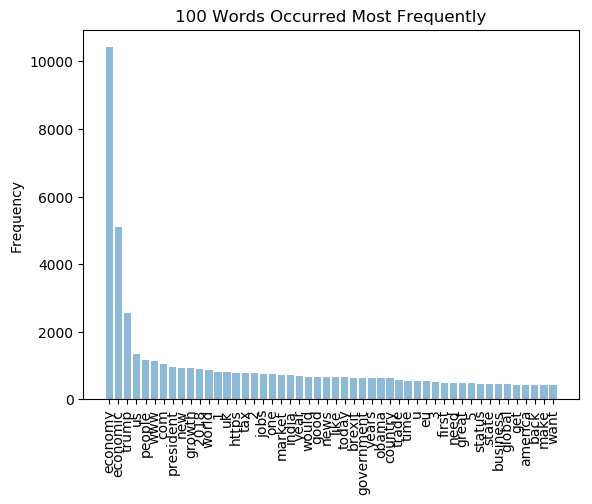

In [13]:
# draw a bar chart to show the frequency of the 100 most common words
x_word = word_freq_dist.iloc[0:50,0]
y_pos = np.arange(len(x_word))
y_freq = word_freq_dist.iloc[0:50,1]

plt.bar(y_pos, y_freq, align='center', alpha=0.5)
plt.xticks(y_pos, x_word)
plt.ylabel('Frequency')
plt.title('100 Words Occurred Most Frequently')
plt.xticks(rotation=90)
 
plt.show()

In [14]:
#split Tweet data into trainning set and text set 
#total tweet data is 20478, 60% will be used to train the model.
train_sentiment=tweetData.iloc[0:12285,:]
test_sentiment=tweetData.iloc[12285:,:]

In [15]:
# Creating the model and setting values for the various parameters
num_features = 300  # Word vector dimensionality
min_word_count = 40 # Minimum word count
num_workers = 5     # Number of parallel threads
context = 10       # Context window size
downsampling = 1e-3 # (0.001) Downsample setting for frequent words

# Initializing the train model
model = word2vec.Word2Vec(train_sentiment.tweet,\
                          workers=num_workers,\
                          size=num_features,\
                          min_count=min_word_count,\
                          window=context,
                          sample=downsampling)

# To make the model memory efficient
model.init_sims(replace=True)

# Saving the model for later use. Can be loaded using Word2Vec.load()
model_name = "300features_40minwords_10context"
model.save(model_name)

In [16]:
# This will give the total number of words in the vocabolary created from this dataset
model.wv.syn0.shape

/Users/Mandy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  


(724, 300)

In [17]:
# This will print the most similar words present in the model
model.wv.most_similar("economic")

[('development', 0.989784836769104),
 ('blockchain', 0.9859371781349182),
 ('join', 0.9832646250724792),
 ('meet', 0.9829401969909668),
 ('opportunities', 0.9826288223266602),
 ('security', 0.9824309945106506),
 ('must', 0.9812912940979004),
 ('help', 0.9803941249847412),
 ('minister', 0.9798327088356018),
 ('sharing', 0.9786492586135864)]

In [18]:
# Function to average all word vectors in a paragraph
def featureVecMethod(words, model, num_features):
    # Pre-initialising empty numpy array for speed
    featureVec = np.zeros(num_features,dtype="float32")
    nwords = 0
    
    #Converting Index2Word which is a list to a set for better speed in the execution.
    index2word_set = set(model.wv.index2word)
    
    for word in  words:
        if word in index2word_set:
            nwords = nwords + 1
            featureVec = np.add(featureVec,model[word])
    
    # Dividing the result by number of words to get average
    featureVec = np.divide(featureVec, nwords)
    return featureVec

In [19]:
#Vectorize the training set
train_FeatureVecs = np.zeros((len(train_sentiment),num_features),dtype="float32")
counter=0
for tweet in train_sentiment.iterrows():
    train_FeatureVecs[counter,:] = featureVecMethod(tweet[1][2], model, num_features)
    counter=counter+1
#testing: print out the first 50 features of the first training tweet
print(train_FeatureVecs[0,0:50])
print(counter)

/Users/Mandy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
/Users/Mandy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


[-0.04000288 -0.11311413 -0.09602176 -0.06871074  0.04472193 -0.00969254
 -0.02233564  0.03924254 -0.02402465 -0.02628223  0.0477214   0.01875035
  0.02244944  0.04290084 -0.04999906 -0.08184449 -0.07652938  0.03123887
 -0.04368056 -0.01625841 -0.05166475 -0.02981452 -0.04443652  0.03291449
  0.03122987  0.01861683 -0.07467189 -0.03429594 -0.02501696  0.0167922
 -0.00161176 -0.04534354 -0.02768772  0.01045812 -0.0121489  -0.03999127
 -0.0233763  -0.02184102 -0.02179841 -0.02960465 -0.01982565 -0.00712194
 -0.04168474  0.02966636  0.01254813 -0.05203638  0.02069862 -0.03473642
  0.01114224  0.01128018]
12285


In [20]:
#Vectorize the test set
test_FeatureVecs=np.zeros((len(test_sentiment),num_features),dtype="float32")
counter_test=0
for each_test_tweet in test_sentiment.iterrows():
    test_FeatureVecs[counter_test,:] = featureVecMethod(each_test_tweet[1][2], model, num_features)
    counter_test=counter_test+1
#testing: print out the first 50 features of the first testing tweet
print(test_FeatureVecs[0,0:50])
print(counter_test)

/Users/Mandy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
/Users/Mandy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


[-0.02747561 -0.06585713 -0.08937731 -0.07631008  0.01451673  0.01975163
  0.01248305  0.05375655 -0.05077156 -0.04878233  0.0093035   0.05157271
 -0.01022585  0.02825828 -0.05512326 -0.06372163 -0.11801393  0.00772628
 -0.02014721 -0.01387685 -0.05237973  0.01008065 -0.02993418  0.06523271
  0.00497482  0.03030078 -0.09340003 -0.03426038 -0.00218461 -0.00437213
 -0.01668992 -0.03380261 -0.01022963  0.03768908 -0.01568774 -0.02452021
 -0.05538839  0.03042624 -0.04067121 -0.00504287 -0.03227342  0.00094154
 -0.05844766  0.05303215 -0.0093339  -0.06064101 -0.0072317  -0.02854183
  0.00509829  0.01406689]
8196


In [21]:
#test if the vectorized feature sets with NaN values and turn them to zero
if np.any(np.isnan(train_FeatureVecs))=='True':
    where_are_NaNs = np.isnan(train_FeatureVecs)
    train_FeatureVecs[where_are_NaNs] = 0
    print(np.any(np.isnan(train_FeatureVecs)))
else:
    print('No NaN values in train_FeatureVecs')
#for test_set
if np.any(np.isnan(test_FeatureVecs))=="True":
    where_are_NaNs = np.isnan(test_FeatureVecs)
    test_FeatureVecs[where_are_NaNs] = 0
    print(np.any(np.isnan(test_FeatureVecs)))
else:
    print('No NaN values in test_FeatureVecs')

No NaN values in train_FeatureVecs
No NaN values in test_FeatureVecs


In [22]:
#test if the vectorized feature sets with infinite numbers and replace them with zeros
if np.all(np.isfinite(train_FeatureVecs))=="False":
    where_are_infinites=np.isinf(train_FeatureVecs)
    train_FeatureVecs[where_are_infinites] = 0
    print(np.all(np.isfinite(train_FeatureVecs)))
else:
    print('No infinite values in train_FeatureVecs')
#for test_set
if np.all(np.isfinite(test_FeatureVecs))=="False":
    where_are_infinites=np.isinf(test_FeatureVecs)
    test_FeatureVecs[where_are_infinites] = 0
    print(np.all(np.isfinite(test_FeatureVecs)))
else:
    print('No infinite values in test_FeatureVecs')

No infinite values in train_FeatureVecs
No infinite values in test_FeatureVecs


In [23]:
train_FeatureVecs = Imputer().fit_transform(train_FeatureVecs)
test_FeatureVecs = Imputer().fit_transform(test_FeatureVecs)

In [24]:
# Fitting a random forest classifier to the training data
RF_classifier = RandomForestClassifier(n_estimators = 300) 
RF_classifier = RF_classifier.fit(train_FeatureVecs, train_sentiment["score"])

In [25]:
# Predicting the sentiment values for test data
result = RF_classifier.predict(test_FeatureVecs)
output = pd.DataFrame(data={"date":test_sentiment["date"], "score":result})
output.to_csv( "/Users/Mandy/Desktop/output.csv", index=False, quoting=3 )
print(output.head())

         date  score
13095  3/1/18  1    
13096  3/1/18  0    
13098  3/1/18 -1    
13099  3/1/18  1    
13100  3/1/18  0    


In [30]:
RF_accuracy=RF_classifier.score(test_FeatureVecs,test_sentiment['score'])
print(RF_accuracy)
print(RF_classifier.predict_proba(test_FeatureVecs))

0.33601756954612005
[[0.26422222 0.34311111 0.39266667]
 [0.21527778 0.5175     0.26722222]
 [0.53750289 0.38506852 0.0774286 ]
 ...
 [0.31828055 0.27024898 0.41147047]
 [0.30376293 0.22305786 0.47317921]
 [0.25756542 0.39169852 0.35073606]]


In [78]:
#for each tweet's vectorized features, the model predict a score. Calculare the score mean
score_class=list([1,0,-1])
score_class=np.matrix(score_class)
expected_score_list=[]
for x in test_FeatureVecs:
    prob=np.matrix(RF_classifier.predict_proba(x.reshape(1, -1)))
    expected_score_list.extend(score_class*prob.transpose())
print(expected_score_list)

[matrix([[-0.12844444]]), matrix([[-0.05194444]]), matrix([[0.46007429]]), matrix([[-0.0235]]), matrix([[0.07194444]]), matrix([[0.13472222]]), matrix([[-0.23875]]), matrix([[-0.53627778]]), matrix([[0.25458333]]), matrix([[-0.10277778]]), matrix([[-0.12289286]]), matrix([[-0.09088889]]), matrix([[-0.03066667]]), matrix([[-0.1850525]]), matrix([[0.11857986]]), matrix([[0.11622222]]), matrix([[-0.14266667]]), matrix([[-0.83916667]]), matrix([[-0.83916667]]), matrix([[-0.117]]), matrix([[0.08444444]]), matrix([[-0.03622222]]), matrix([[0.00388889]]), matrix([[-0.40283333]]), matrix([[-0.20527778]]), matrix([[0.05068254]]), matrix([[0.105]]), matrix([[-0.1475]]), matrix([[-0.03422222]]), matrix([[-0.02209921]]), matrix([[0.09281746]]), matrix([[0.1575]]), matrix([[0.11857986]]), matrix([[0.00277778]]), matrix([[0.21277778]]), matrix([[0.05861111]]), matrix([[0.18083333]]), matrix([[0.05338889]]), matrix([[-0.06361111]]), matrix([[-0.11369048]]), matrix([[-0.11438889]]), matrix([[0.0516666